In [27]:
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
from astropy import units as u
import pandas as pd
from scipy.interpolate import interp1d

In [28]:
from lsst.geom import Point2D, Point2I
from lsst.afw.cameraGeom import FIELD_ANGLE, PIXELS
import lsst.afw.cameraGeom.utils as cgUtils
from lsst.daf.persistence import Butler, NoResults

In [29]:
from rubin_sim.photUtils import PhotometricParameters, Bandpass, LSSTdefaults
from rubin_sim.utils import angularSeparation
import syseng_throughputs as st

In [30]:
#rname = 'R10'
#rname = 'R22'
#rname = 'R01'
#rname = 'R11'
#rname = 'R20'
#rname = 'R21'
rname = 'R30'
#rname = 'R12'
#rname = 'R02'
#rname = 'R31'
#rname = 'R03'
#rname = 'R34'
#rname = 'R13'
#rname = 'R23'
#rname = 'R14'
#rname = 'R32'
#rname = 'R24'
#rname = 'R41'
#rname = 'R42'
#rname = 'R33'
#rname = 'R43'

In [31]:
# mapping based on 
#https://confluence.slac.stanford.edu/pages/viewpage.action?spaceKey=LSSTCAM&title=Raft+Delivery+and+Acceptance+Testing+Status
dd = pd.read_csv('raftInstall.csv',index_col=0)
useDefault = False
try:
    if np.isnan(dd.rtm[rname]):
        useDefault = True
        print('no data yet, use default')
except TypeError:
    pass

In [32]:
dd.rtm

R00        NaN
R01    RTM-011
R02    RTM-013
R03    RTM-017
R04        NaN
R10    RTM-023
R11    RTM-020
R12    RTM-009
R13    RTM-019
R14    RTM-006
R20    RTM-014
R21    RTM-025
R22    RTM-024
R23    RTM-005
R24    RTM-008
R30    RTM-012
R31    RTM-007
R32    RTM-015
R33    RTM-010
R34    RTM-016
R40        NaN
R41    RTM-021
R42    RTM-018
R43    RTM-022
R44        NaN
Name: rtm, dtype: object

### Default photometric parameters, as used in standard m5 calculations
Note that effarea is not in this list here, because it varies with field.

The read noise is not in this list either, because it varies by amp.

In [33]:
exptime=15 
nexp=2
othernoise=0 
darkcurrent=0.2
X=1.0

In [34]:
#we do not need this cell to calculate m5, but these FWHMeff are the default values we use actually
lsstDefaults = LSSTdefaults()

### Set up throughputs for hardware and atmosphere. Use the default detector QE as in syseng_throughput for now

In [35]:
# Add losses to each component?
addLosses = False
defaultDirs = st.setDefaultDirs()
defaultDirs

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}

In [36]:
atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')
mirror1 = st.buildMirror(defaultDirs['mirror1'], addLosses)
mirror2 = st.buildMirror(defaultDirs['mirror2'], addLosses)
mirror3 = st.buildMirror(defaultDirs['mirror3'], addLosses)
lens1 = st.buildLens(defaultDirs['lens1'], addLosses)
lens2 = st.buildLens(defaultDirs['lens2'], addLosses)
lens3 = st.buildLens(defaultDirs['lens3'], addLosses)
filters = st.buildFilters(defaultDirs['filters'], addLosses)

vendor = dd.vendor[rname]
vendorDir = defaultDirs['detector']+'/../'+vendor.lower()
detector0 = st.buildDetector(vendorDir, addLosses) #design QE from this vendor
detector = Bandpass()

In [58]:
e2v_detector = st.buildDetector(defaultDirs['detector'] + '/../' + 'e2v', addLosses)
itl_detector = st.buildDetector(defaultDirs['detector'] + '/../' + 'itl', addLosses)


In [37]:
for f in filters:
    print(f, lsstDefaults.FWHMeff(f), lsstDefaults.m5(f))

r 0.83 24.43
i 0.8 24.0
u 0.92 23.68
y 0.76 22.6
g 0.87 24.89
z 0.78 24.45


### Butler access to the QE data

In [38]:
DATADIR = f"{os.environ['OBS_LSST_DIR']}/lsstcam/CALIB" 
print(DATADIR)
butler = Butler(DATADIR)
cam = butler.get('camera')

#This is no longer needed after tickets/DM-22605
#from lsst.obs.lsst.lsstCamMapper import LsstCamMapper
#mapper = LsstCamMapper()
#lsstcam = mapper.camera

/Users/lynnej/lsst_stack/stack/miniconda3-py38_4.9.2-0.7.0/DarwinX86/obs_lsst/22.0.1-61-gbd5239c+96886d66ff/lsstcam/CALIB
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /Users/lynnej/lsst_stack/stack/miniconda3-py38_4.9.2-0.7.0/DarwinX86/obs_lsst/22.0.1-61-gbd5239c+96886d66ff/lsstcam/CALIB
lsst.CameraMapper INFO: Loading calib registry from /Users/lynnej/lsst_stack/stack/miniconda3-py38_4.9.2-0.7.0/DarwinX86/obs_lsst/22.0.1-61-gbd5239c+96886d66ff/lsstcam/CALIB/calibRegistry.sqlite3


### Prepare vignetting function

In [39]:
# below we use v3.11 values
vfile = f"{os.environ['HOME']}/other_repos/f_factors/data/vignettingF.txt"
M1D = 8.36 #clear aperture as in Optical design
aa = np.loadtxt(vfile, skiprows=12)
vr = aa[:,0]
vv = aa[:,1]

### Create the dataframes for this raft

In [40]:
#filterlist = tuple([s for s in filters]+['fS']) # this would be in different order than below
filterlist = ['u', 'g', 'r', 'i', 'z', 'y', 'fS', 'u1', 'u2']
alist = ('raDeg', 'decDeg', 'radDeg', 'effarea', 'readnoise', 'gain', 'saturation')
detectors = []
for det in cam:
    rname1, dname = det.getName().split('_')
    if rname1 != rname: 
        continue;
    detectors.append(det.getName())
adf = pd.DataFrame(index=alist, columns=detectors, dtype=object)
m5df = pd.DataFrame(index=filterlist, columns=detectors, dtype=object)
Tdf = pd.DataFrame(index=filterlist[:6], columns=detectors, dtype=object)
Sdf = pd.DataFrame(index=filterlist[:6], columns=detectors, dtype=object)

In [41]:
for det in cam:
    rname1, dname = det.getName().split('_')
    if rname1 != rname: 
        continue;
    key = rname+'_'+dname
    raDeg = {}
    decDeg = {}
    readnoise = {}
    gain = {}
    saturation = {}
    for amp in det:
        i = amp.getName()
        amp_point = amp.getBBox().getCenter()
        raDec = det.transform(amp_point, PIXELS, FIELD_ANGLE) 
        [raDeg[i], decDeg[i]] = np.degrees(raDec)
        gain[i] = amp.getGain()
        saturation[i] = amp.getSaturation()
        #print(key, i, raDec, amp.getGain(), amp.getSaturation())
        if useDefault:
            readnoise[i] = 8.8
        else:
            readnoise[i] = amp.getReadNoise()
    adf[key].loc['raDeg'] = list(raDeg.values())
    adf[key].loc['decDeg'] = list(decDeg.values())
    adf[key].loc['readnoise'] = list(readnoise.values())
    adf[key].loc['gain'] = list(gain.values())
    adf[key].loc['saturation'] = list(saturation.values())
    
    #effective area
    radius = angularSeparation(0., 0., adf[key]['raDeg'], adf[key]['decDeg'])
    adf[key].loc['radDeg'] = list(radius)
    adf[key].loc['effarea'] = list(np.interp(radius, vr, vv)*np.pi*(M1D/2)**2)

In [42]:
# Substitute in the readnoise from the pickle files
filename = 'readnoise_13060.pkl'
readnoise = pd.read_pickle(filename)
adf.loc['readnoise'] = readnoise

In [43]:
adf.loc['readnoise']

R30_S00    [4.1374916040420535, 5.091834951400757, 4.7705...
R30_S01    [4.810245618629455, 4.680577557373047, 4.70235...
R30_S02    [4.8474418718338015, 4.763395443534851, 4.7885...
R30_S10    [4.56172806148529, 4.589891696739197, 4.612863...
R30_S11    [4.743858529090882, 4.763878501319885, 4.79221...
R30_S12    [4.969547386169434, 5.068382134246826, 5.15516...
R30_S20    [4.820920311546326, 4.8001452098846435, 4.8145...
R30_S21    [4.714503726387024, 4.892148829650879, 4.81013...
R30_S22    [4.934584772872925, 5.172272512054444, 5.03232...
Name: readnoise, dtype: object

In [44]:
for k in adf:
    updated = (adf[k].loc['readnoise'] == readnoise[k])
    if not updated:
        print(k)

In [45]:
adf

,R30_S00,R30_S01,R30_S02,R30_S10,R30_S11,R30_S12,R30_S20,R30_S21,R30_S22
raDeg,"[-1.7453888888888889, -1.7169444444444446, -1....","[-1.5106666666666668, -1.4822222222222223, -1....","[-1.2759444444444445, -1.2474999999999998, -1....","[-1.745388888888889, -1.7169444444444444, -1.6...","[-1.5106666666666666, -1.4822222222222223, -1....","[-1.2759444444444443, -1.2474999999999998, -1....","[-1.7453888888888889, -1.7169444444444446, -1....","[-1.5106666666666668, -1.4822222222222223, -1....","[-1.2759444444444445, -1.2474999999999998, -1...."
decDeg,"[0.5264444444444445, 0.5264444444444445, 0.526...","[0.5264444444444445, 0.5264444444444444, 0.526...","[0.5264444444444444, 0.5264444444444445, 0.526...","[0.7611666666666667, 0.7611666666666665, 0.761...","[0.7611666666666665, 0.7611666666666667, 0.761...","[0.7611666666666667, 0.7611666666666667, 0.761...","[0.9958888888888889, 0.9958888888888889, 0.995...","[0.9958888888888889, 0.9958888888888892, 0.995...","[0.9958888888888892, 0.9958888888888889, 0.995..."
radDeg,"[1.82303055177313, 1.7958170887758695, 1.76864...","[1.599747888482191, 1.5729159675183553, 1.5461...","[1.3802652506716695, 1.3540148473870788, 1.327...","[1.904095018228308, 1.87805736994685, 1.852090...","[1.691553785569307, 1.6662017154153084, 1.6409...","[1.4857029109129658, 1.461348482447231, 1.4371...","[2.0094452563807916, 1.9847911753110985, 1.960...","[1.8093309865827332, 1.7856528586036753, 1.762...","[1.6185379028055409, 1.5962124534640756, 1.574..."
effarea,"[26.361544598879586, 28.441128018412183, 30.10...","[31.935641382978663, 32.09273444922376, 32.242...","[32.97585481711575, 33.0976621831972, 33.16436...","[20.82337609398156, 22.300659387872553, 24.002...","[31.419476502043967, 31.558240623202607, 31.69...","[32.54792406646528, 32.66267275446668, 32.7877...","[10.128748365165558, 13.289027057923798, 15.76...","[27.44085061205761, 29.134546869554153, 30.433...","[31.7914281811739, 31.95666823271608, 32.08619..."
readnoise,"[4.1374916040420535, 5.091834951400757, 4.7705...","[4.810245618629455, 4.680577557373047, 4.70235...","[4.8474418718338015, 4.763395443534851, 4.7885...","[4.56172806148529, 4.589891696739197, 4.612863...","[4.743858529090882, 4.763878501319885, 4.79221...","[4.969547386169434, 5.068382134246826, 5.15516...","[4.820920311546326, 4.8001452098846435, 4.8145...","[4.714503726387024, 4.892148829650879, 4.81013...","[4.934584772872925, 5.172272512054444, 5.03232..."
gain,"[1.6, 1.17972, 1.16543, 1.15903, 1.15541, 1.16...","[1.1468, 1.14407, 1.13297, 1.148, 1.15029, 1.1...","[1.20155, 1.2008, 1.20514, 1.21039, 1.21143, 1...","[1.0881, 1.09728, 1.09737, 1.09793, 1.08965, 1...","[1.15852, 1.17091, 1.17419, 1.16892, 1.18659, ...","[1.22929, 1.23124, 1.22958, 1.22569, 1.22971, ...","[1.17364, 1.18482, 1.18702, 1.17705, 1.18984, ...","[1.12508, 1.12769, 1.13194, 1.12031, 1.13283, ...","[1.14657, 1.15485, 1.16126, 1.17265, 1.16882, ..."
saturation,"[142857.0, 119049.0, 108861.0, 110258.0, 11194...","[119300.0, 121389.0, 110842.0, 110996.0, 10043...","[112395.0, 114490.0, 115481.0, 104084.0, 10536...","[66834.0, 118099.0, 107576.0, 110137.0, 113379...","[100727.0, 113916.0, 115204.0, 104174.0, 10475...","[94193.0, 95636.0, 96857.0, 97972.0, 99014.0, ...","[101773.0, 103058.0, 104478.0, 106771.0, 10753...","[122359.0, 111165.0, 125832.0, 113848.0, 11387...","[116981.0, 118012.0, 106210.0, 106029.0, 10720..."


In [46]:
ampList = list(raDeg.keys())

In [47]:
# this is needed if there are only 6 QE measurements per amp
idx = np.where(detector0.sb>0.01)
idx1=idx[0][0]-1
idx2=idx[0][-1]+1

x1 = detector0.wavelen[idx1]
y1 = detector0.sb[idx1]
x2 = detector0.wavelen[idx2]
y2 = detector0.sb[idx2]

In [48]:
m5SRD = np.array([23.9, 25.0, 24.7, 24.0, 23.3, 22.1])
#m5SRDmin = []
# Nv1 from SRD table 24
Nv1 = np.array([56, 80, 184, 184, 160, 160])
omega = Nv1/sum(Nv1)
fidx = 'ugrizy' #very important!

In [49]:
qes = {}
for det in cam:
    rname1, dname = det.getName().split('_')
    if rname1 != rname: 
        continue;
        
    vendor = det.getSerial()[:3].lower()
    assert useDefault or dd.vendor[rname].lower() == vendor
    vendorDir = defaultDirs['detector']+'/../'+vendor
    print('Calculating m5 for %s_%s'%(rname,dname))
    
    key = rname+'_'+dname
    for f in filterlist:
        m5df[key][f] = [-1.]*len(ampList)
    for f in filterlist[:6]:
        Tdf[key][f] = [-1.]*len(ampList)
        Sdf[key][f] = [-1.]*len(ampList)
        
    for amp in det:
        
        try:
            qe_curve = butler.get('qe_curve', raftName=rname, detectorName=dname, calibDate='1970-01-01T00:00:00')
            wavelen = detector0.wavelen 

            k = amp.getName()
            if len(qe_curve.data[k][0])>10:
                wlen = qe_curve.data[k][0]
                eff = qe_curve.data[k][1]
                f = interp1d(wlen.value, eff.value, fill_value=0, bounds_error=False, kind='quadratic')
            else:
                aa = np.append(x1, qe_curve.data[k][0].value)
                aa = np.append(aa, x2)
                wlen = aa * qe_curve.data[k][0].unit

                aa = np.append(y1, qe_curve.data[k][1].value)
                aa = np.append(aa, y2)
                eff = aa * qe_curve.data[k][1].unit
                f = interp1d(wlen.value, eff.value, fill_value=0, bounds_error=False, kind='slinear')#quadratic causes overshoot
            
            sb = f(wavelen)*0.01
            #alternatively we could do (only for >10 QE measurements)
            #amp_point = amp.getBBox().getCenter()
            #sb = qe_curve.evaluate(det, amp_point, wavelen* u.nm, kind='quadratic').value*.01 #unit was percent in CALIB data

            sb[np.isnan(sb)] = 0
            if np.max(sb)>1.5:
                print('These seem too LARGE ', k)
                print(np.max(sb))
                sb = 0
            if np.max(sb)<0.2: #3 dead channels, 1 out of each of R01, R10, and R30; see camera confluence page table
                print('dead channel: %s %s, max sb = %.2f'%(key, amp.getName(), np.max(sb)))
                continue;
                
            detector.setBandpass(wavelen, sb)
            qes[amp] = copy.deepcopy(detector)
                
            #detector losses  
            #os.listdir(vendorDir)
            detLosses = Bandpass()
            detLosses.readThroughput(os.path.join(vendorDir, '%s_Losses/det_Losses.dat' % (vendor)))
                
            #build hardware and system
            hardware = {}
            system = {}
            for f in filters:
                sb = mirror1.sb * mirror2.sb *mirror3.sb
                sb *= lens1.sb * lens2.sb * lens3.sb * filters[f].sb
                sb *= detector.sb 
                if addLosses:
                    sb *= detLosses.sb
                
                hardware[f] = Bandpass()
                hardware[f].setBandpass(wavelen, sb)
                system[f] = Bandpass()
                system[f].setBandpass(wavelen, sb * atmos.sb)
                
        except NoResults:
            if not useDefault:
                print('No results found for this detector')
            assert useDefault
            
            hardware, system = st.buildHardwareAndSystem(defaultDirs)
            
        #calculate m5      
        iamp = ampList.index(amp.getName())
        effarea = adf[key]['effarea'][iamp]*100**2 #convert to cm^2
        readnoise = adf[key]['readnoise'][iamp]
        
        m5 = st.makeM5(hardware, system, darksky=None, 
                    exptime=15, nexp=2, readnoise=readnoise, othernoise=0, darkcurrent=0.2,
                    effarea=effarea, X=1.0)
        for f in filters:
            m5df[key][f][iamp] = m5.m5[f]
            Tdf[key][f][iamp] = m5.Tb[f]
            Sdf[key][f][iamp] = m5.Sb[f]
        m5amp = np.array([m5.m5[f] for f in fidx])
        if np.all(m5amp>0):
            m5df[key]['fS'][iamp] = sum(omega*10**(0.8*(m5amp - m5SRD)))
        
        #what about u-band with 1min & 2 min visits?
        m5 = st.makeM5(hardware, system, darksky=None, 
                    exptime=30, nexp=2, readnoise=readnoise, othernoise=0, darkcurrent=0.2,
                    effarea=effarea, X=1.0)
        m5df[key]['u1'][iamp] = m5.m5['u']
        m5 = st.makeM5(hardware, system, darksky=None, 
                    exptime=60, nexp=2, readnoise=readnoise, othernoise=0, darkcurrent=0.2,
                    effarea=effarea, X=1.0)
        m5df[key]['u2'][iamp] = m5.m5['u']        

Calculating m5 for R30_S00
dead channel: R30_S00 C10, max sb = 0.00
Calculating m5 for R30_S01
Calculating m5 for R30_S02
Calculating m5 for R30_S10
Calculating m5 for R30_S11
Calculating m5 for R30_S12
Calculating m5 for R30_S20
Calculating m5 for R30_S21
Calculating m5 for R30_S22


(0.0, 1.1)

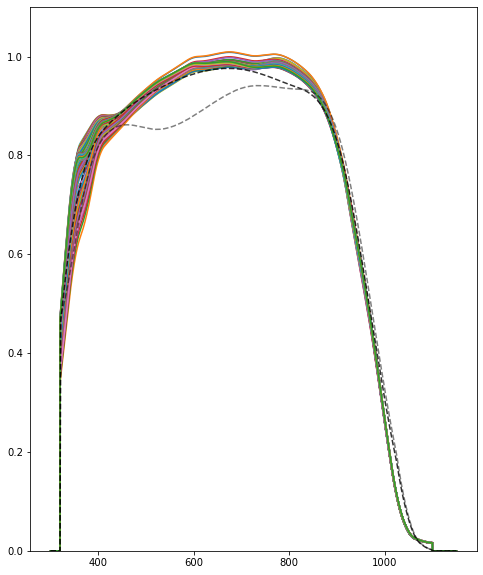

In [62]:
plt.figure(figsize=(8, 10))
for k in qes.keys():
    plt.plot(qes[k].wavelen, qes[k].sb)
plt.plot(e2v_detector.wavelen, e2v_detector.sb, 'k--', alpha=0.8)
plt.plot(itl_detector.wavelen, itl_detector.sb, 'k--', alpha=0.5)
plt.ylim(0, 1.1)

In [45]:
Sdf

,R30_S00,R30_S01,R30_S02,R30_S10,R30_S11,R30_S12,R30_S20,R30_S21,R30_S22
u,"[-1.0, 0.06154937586510725, 0.0626040150907606...","[0.06037149337873526, 0.06042585549765392, 0.0...","[0.0660715469507539, 0.0663100243845133, 0.066...","[0.0640097450636556, 0.06422593903031298, 0.06...","[0.06271665714470147, 0.06315560314888394, 0.0...","[0.06269230710481181, 0.06302283678340426, 0.0...","[0.05635422107504147, 0.056854755712280165, 0....","[0.05337752577786103, 0.054419156054395276, 0....","[0.06564604106058808, 0.06593293795859133, 0.0..."
g,"[-1.0, 0.16152265806240457, 0.1622574328308559...","[0.1604113311225688, 0.16023955809914517, 0.16...","[0.16408266705841365, 0.16402995216594377, 0.1...","[0.1622343388239926, 0.16222468641696786, 0.16...","[0.1617764348312566, 0.16205074263712316, 0.16...","[0.16375941892021834, 0.16382646651369914, 0.1...","[0.15965076487790222, 0.1596999811062883, 0.15...","[0.15917875064617065, 0.1599292480875684, 0.16...","[0.16390926270406403, 0.16423737354117202, 0.1..."
r,"[-1.0, 0.12599178444507272, 0.126290587591704,...","[0.12606507274110543, 0.12588431194893387, 0.1...","[0.12676460700246142, 0.1266250272252422, 0.12...","[0.12631499858325848, 0.1262411085605333, 0.12...","[0.1267989023834329, 0.12689625161786872, 0.12...","[0.12755675536206, 0.12749719391404757, 0.1273...","[0.12636071640934682, 0.12621272866177524, 0.1...","[0.12661332889518617, 0.12687613703406844, 0.1...","[0.1272278337237196, 0.12742947514027747, 0.12..."
i,"[-1.0, 0.08909186229518212, 0.0893175961506185...","[0.08906851043138493, 0.08890999510536848, 0.0...","[0.08944150459011213, 0.0894223410453633, 0.08...","[0.0889519700520108, 0.08902473759883549, 0.08...","[0.08918112065692196, 0.08922018780154144, 0.0...","[0.08941588028418557, 0.08946033113910305, 0.0...","[0.08913851923094988, 0.0891818545830674, 0.08...","[0.08996436389296032, 0.09012578727054739, 0.0...","[0.08954264544761932, 0.08977135648521711, 0.0..."
z,"[-1.0, 0.058413158139835546, 0.058543327156238...","[0.058285087736084415, 0.058173536407611054, 0...","[0.05851665697381591, 0.05855085928741756, 0.0...","[0.05822237280652388, 0.058305719591582865, 0....","[0.05809172095929657, 0.05811628747865292, 0.0...","[0.05813440386085391, 0.0582164315231135, 0.05...","[0.058318488215753035, 0.058339839125876924, 0...","[0.05895898261596234, 0.05905151191059104, 0.0...","[0.058372468338071276, 0.058611004534876866, 0..."
y,"[-1.0, 0.028387703008441015, 0.028439531653337...","[0.028247899604630304, 0.028260852722787975, 0...","[0.028516912047298497, 0.028529138436077843, 0...","[0.02822577306144989, 0.028215534828375365, 0....","[0.028083564176793904, 0.028118534682284018, 0...","[0.028071344922707624, 0.028092304259505704, 0...","[0.028286939354991106, 0.028247018696968967, 0...","[0.028394058260150422, 0.028446399547457313, 0...","[0.028307004538634765, 0.02845835733293644, 0...."


In [46]:
m5df

,R30_S00,R30_S01,R30_S02,R30_S10,R30_S11,R30_S12,R30_S20,R30_S21,R30_S22
u,"[-1.0, 24.108896516803814, 24.191122943260716,...","[24.204939983461834, 24.218967128458708, 24.22...","[24.294640217252667, 24.305830225447668, 24.30...","[23.936202701865618, 23.9908297585998, 24.0517...","[24.224943360752015, 24.232010955172242, 24.23...","[24.235973088626025, 24.23534215600516, 24.235...","[23.176629511814237, 23.43243199026756, 23.588...","[24.002829176198475, 24.050270712556838, 24.10...","[24.25057049114008, 24.240690781320037, 24.254..."
g,"[-1.0, 24.873113663787237, 24.918598213602735,...","[24.946609385752172, 24.95171471421705, 24.955...","[24.97980032713833, 24.98359947946307, 24.9841...","[24.694776664202163, 24.737099522415747, 24.78...","[24.943370604003526, 24.946703242173538, 24.94...","[24.96763355590698, 24.967952971800543, 24.968...","[24.192663935206983, 24.381713278226133, 24.49...","[24.85033974972037, 24.88610320781064, 24.9152...","[24.954571372335693, 24.953778897180516, 24.95..."
r,"[-1.0, 24.392908856772607, 24.431378805025275,...","[24.46421655230047, 24.467646983255907, 24.471...","[24.4856805362181, 24.488077151042752, 24.4884...","[24.218081636506973, 24.257834190047035, 24.30...","[24.458871123446198, 24.461653724659328, 24.46...","[24.480398349967736, 24.481075249092857, 24.48...","[23.770372567672517, 23.941047104938594, 24.04...","[24.379555054197287, 24.413554077756878, 24.43...","[24.465703872922816, 24.466908921406475, 24.46..."
i,"[-1.0, 23.92597263918075, 23.96290594800366, 2...","[23.9951117665254, 23.997978120071885, 24.0019...","[24.015400803449246, 24.017951071738974, 24.01...","[23.75061940685484, 23.790404617021444, 23.833...","[23.987499176537998, 23.99013488564541, 23.992...","[24.007301333590785, 24.008672034950052, 24.01...","[23.316248512751823, 23.48246436519572, 23.584...","[23.914227116233548, 23.94805087005591, 23.972...","[23.994186891456202, 23.996498731338406, 23.99..."
z,"[-1.0, 23.32618690806114, 23.36163392959383, 2...","[23.3923019917318, 23.394666702895904, 23.3985...","[23.412506660015527, 23.41540218582567, 23.416...","[23.150625515865652, 23.19040049496605, 23.232...","[23.38161833632307, 23.384185512838783, 23.386...","[23.400892658295206, 23.40310961971053, 23.405...","[22.728857867306967, 22.89035215768255, 22.990...","[23.314045559326946, 23.347680586810682, 23.37...","[23.390554531873562, 23.39429926746994, 23.397..."
y,"[-1.0, 22.370921753727277, 22.40556277392367, ...","[22.43470052059612, 22.438230941353247, 22.442...","[22.45776006151207, 22.460470743689015, 22.461...","[22.194068556853026, 22.232586446482298, 22.27...","[22.422683306224236, 22.42574594312246, 22.428...","[22.441177036635935, 22.443122238748522, 22.44...","[21.776748643539378, 21.935230647132023, 22.03...","[22.352914074204108, 22.386669363616384, 22.41...","[22.432609920088822, 22.437331288400856, 22.44..."
fS,"[-1.0, 1.0219822036551842, 1.1028835699374189,...","[1.1629800884355976, 1.1723712726559552, 1.181...","[1.2285379610878189, 1.2370268423381305, 1.239...","[0.7393226875983658, 0.7973976706369899, 0.865...","[1.1500708523527363, 1.157088156459158, 1.1625...","[1.1908559798434282, 1.1937849239676053, 1.197...","[0.31839121971975826, 0.43569450498855244, 0.5...","[0.9789080365844482, 1.0442682336328142, 1.097...","[1.172628875059715, 1.1761438955612062, 1.1867..."
u1,"[-1.0, 24.610510684476598, 24.677766876229462,...","[24.69109005163611, 24.700896661343954, 24.706...","[24.773564704973474, 24.781919117859935, 24.78...","[24.440979556065624, 24.491281068751846, 24.54...","[24.707565765681515, 24.71444100263357, 24.718...","[24.722761311183874, 24.724337876454527, 24.72...","[23.755035933055858, 23.988980651907507, 24.13...","[24.5059120556817, 24.55319365324359, 24.59726...","[24.734429891782447, 24.730604307091937, 24.74..."
u2,"[-1.0, 25.063735715954945, 25.12049476382624, ...","[25.133464614411096, 25.140414179105186, 25.14...","[25.21099087341154, 25.217460959306102, 25.219...","[24.8

In [47]:
dfDir = os.path.join('m5_output', rname)

In [48]:
if not os.path.exists(dfDir):
    os.mkdir(dfDir)
dfPath = os.path.join(dfDir, 'adf_%s.csv'%rname)
adf.to_csv(dfPath)
dfPath = os.path.join(dfDir, 'm5df_%s.csv'%rname)
m5df.to_csv(dfPath)
dfPath = os.path.join(dfDir, 'Tdf_%s.csv'%rname)
Tdf.to_csv(dfPath)
dfPath = os.path.join(dfDir, 'Sdf_%s.csv'%rname)
Sdf.to_csv(dfPath)

In [49]:
dfDir

'm5_output/R30'

### Make sure we can read out the dataframes correctly

In [36]:
from ast import literal_eval

In [37]:
dfPath = os.path.join(dfDir, 'adf_%s.csv'%rname)
df = pd.read_csv(dfPath, index_col=0)

In [38]:
df['%s_S00'%rname].apply(literal_eval)#['readnoise'][0]

raDeg         [-1.7453888888888889, -1.7169444444444446, -1....
decDeg        [0.5264444444444445, 0.5264444444444445, 0.526...
radDeg        [1.82303055177313, 1.7958170887758695, 1.76864...
effarea       [26.361544598879586, 28.441128018412183, 30.10...
readnoise     [4.553, 5.259, 5.222, 5.453, 5.288, 5.251, 5.3...
gain          [1.6, 1.17972, 1.16543, 1.15903, 1.15541, 1.16...
saturation    [142857.0, 119049.0, 108861.0, 110258.0, 11194...
Name: R30_S00, dtype: object

In [31]:
adf

,R30_S00,R30_S01,R30_S02,R30_S10,R30_S11,R30_S12,R30_S20,R30_S21,R30_S22
raDeg,"[-1.7453888888888889, -1.7169444444444446, -1....","[-1.5106666666666668, -1.4822222222222223, -1....","[-1.2759444444444445, -1.2474999999999998, -1....","[-1.745388888888889, -1.7169444444444444, -1.6...","[-1.5106666666666666, -1.4822222222222223, -1....","[-1.2759444444444443, -1.2474999999999998, -1....","[-1.7453888888888889, -1.7169444444444446, -1....","[-1.5106666666666668, -1.4822222222222223, -1....","[-1.2759444444444445, -1.2474999999999998, -1...."
decDeg,"[0.5264444444444445, 0.5264444444444445, 0.526...","[0.5264444444444445, 0.5264444444444444, 0.526...","[0.5264444444444444, 0.5264444444444445, 0.526...","[0.7611666666666667, 0.7611666666666665, 0.761...","[0.7611666666666665, 0.7611666666666667, 0.761...","[0.7611666666666667, 0.7611666666666667, 0.761...","[0.9958888888888889, 0.9958888888888889, 0.995...","[0.9958888888888889, 0.9958888888888892, 0.995...","[0.9958888888888892, 0.9958888888888889, 0.995..."
radDeg,"[1.82303055177313, 1.7958170887758695, 1.76864...","[1.599747888482191, 1.5729159675183553, 1.5461...","[1.3802652506716695, 1.3540148473870788, 1.327...","[1.904095018228308, 1.87805736994685, 1.852090...","[1.691553785569307, 1.6662017154153084, 1.6409...","[1.4857029109129658, 1.461348482447231, 1.4371...","[2.0094452563807916, 1.9847911753110985, 1.960...","[1.8093309865827332, 1.7856528586036753, 1.762...","[1.6185379028055409, 1.5962124534640756, 1.574..."
effarea,"[26.361544598879586, 28.441128018412183, 30.10...","[31.935641382978663, 32.09273444922376, 32.242...","[32.97585481711575, 33.0976621831972, 33.16436...","[20.82337609398156, 22.300659387872553, 24.002...","[31.419476502043967, 31.558240623202607, 31.69...","[32.54792406646528, 32.66267275446668, 32.7877...","[10.128748365165558, 13.289027057923798, 15.76...","[27.44085061205761, 29.134546869554153, 30.433...","[31.7914281811739, 31.95666823271608, 32.08619..."
readnoise,"[4.553, 5.259, 5.222, 5.453, 5.288, 5.251, 5.3...","[5.161, 5.303, 5.089, 5.175, 5.252, 5.195, 5.1...","[5.21, 5.222, 5.413, 5.269, 5.277, 5.273, 5.33...","[4.948, 5.013, 5.023, 5.228, 5.212, 5.109, 5.2...","[5.244, 5.193, 5.456, 5.228, 5.305, 5.304, 5.2...","[5.683, 6.038, 5.995, 6.067, 5.953, 5.899, 6.2...","[5.332, 5.24, 5.559, 5.241, 5.274, 5.346, 5.29...","[5.227, 5.651, 5.554, 5.164, 5.63, 5.268, 5.42...","[5.511, 5.562, 5.521, 5.72, 6.061, 5.604, 6.76..."
gain,"[1.6, 1.17972, 1.16543, 1.15903, 1.15541, 1.16...","[1.1468, 1.14407, 1.13297, 1.148, 1.15029, 1.1...","[1.20155, 1.2008, 1.20514, 1.21039, 1.21143, 1...","[1.0881, 1.09728, 1.09737, 1.09793, 1.08965, 1...","[1.15852, 1.17091, 1.17419, 1.16892, 1.18659, ...","[1.22929, 1.23124, 1.22958, 1.22569, 1.22971, ...","[1.17364, 1.18482, 1.18702, 1.17705, 1.18984, ...","[1.12508, 1.12769, 1.13194, 1.12031, 1.13283, ...","[1.14657, 1.15485, 1.16126, 1.17265, 1.16882, ..."
saturation,"[142857.0, 119049.0, 108861.0, 110258.0, 11194...","[119300.0, 121389.0, 110842.0, 110996.0, 10043...","[112395.0, 114490.0, 115481.0, 104084.0, 10536...","[66834.0, 118099.0, 107576.0, 110137.0, 113379...","[100727.0, 113916.0, 115204.0, 104174.0, 10475...","[94193.0, 95636.0, 96857.0, 97972.0, 99014.0, ...","[101773.0, 103058.0, 104478.0, 106771.0, 10753...","[122359.0, 111165.0, 125832.0, 113848.0, 11387...","[116981.0, 118012.0, 106210.0, 106029.0, 10720..."


In [32]:
adf['R30_S00'].loc['raDeg']

[-1.7453888888888889,
 -1.7169444444444446,
 -1.6885,
 -1.6600555555555554,
 -1.631611111111111,
 -1.603166666666667,
 -1.5747222222222224,
 -1.546277777777778,
 -1.5462777777777779,
 -1.5747222222222224,
 -1.603166666666667,
 -1.631611111111111,
 -1.6600555555555554,
 -1.6885000000000001,
 -1.7169444444444444,
 -1.7453888888888889]

In [33]:
dfPath = os.path.join(dfDir, 'm5df_%s.csv'%rname)
df = pd.read_csv(dfPath, index_col=0)

In [34]:
df['%s_S00'%rname].apply(literal_eval)#['readnoise'][0]

u     [-1.0, 24.09534443718557, 24.156331810308245, ...
g     [-1.0, 24.868922182198215, 24.908148162488768,...
r     [-1.0, 24.390705024700395, 24.425916769227445,...
i     [-1.0, 23.924334919431107, 23.95885652907621, ...
z     [-1.0, 23.32504867875722, 23.358823538880237, ...
y     [-1.0, 22.369959731866462, 22.40318824032757, ...
fS    [-1.0, 1.016835352719155, 1.0885538175645237, ...
u1    [-1.0, 24.601989509950165, 24.656324666432347,...
u2    [-1.0, 25.058838857060334, 25.108345131285592,...
Name: R30_S00, dtype: object

In [35]:
#df['R01_S11']['u']